In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import butter, filtfilt, find_peaks

In [2]:
## Low Pass Filter for Azure data
def butter_lowpass_filter(data, cutoff, order):
    normal_cutoff=cutoff/(15) 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    x = np.expand_dims(filtfilt(b, a, data[:,0]), axis=-1)
    y = np.expand_dims(filtfilt(b, a, data[:,1]), axis=-1)
    z = np.expand_dims(filtfilt(b, a, data[:,2]), axis=-1)
    filtered = np.concatenate((x, y, z), axis=-1)
    return filtered

In [3]:
def ReadCSV(path):
    
    csv_data = np.loadtxt(path, delimiter=',', dtype=str, skiprows=1, usecols=(101))
    idx_footSwitch = 0
    for i in csv_data:
        if i == ' 0':
            idx_footSwitch += 1
        else:
            break
    
    ## 누락된 데이터 전까지 읽기 위해 line_num 찾는 과정
    csv_data = np.loadtxt(path, delimiter=',', dtype=str, skiprows=1, usecols=(1))
    line_num=csv_data.shape[0]
    for i, v in enumerate(csv_data):
        if v == " ":
            line_num = i
            break
            
    csv_data = np.loadtxt(path, delimiter=',', skiprows=1, max_rows=line_num, usecols=range(1, 101))  
    
    ## 마지막 4개의 항목을 통해 각 데이터가 기록된 시간을 획득(키넥트 기준)
    time = csv_data[:,-4:]
    time_ = time[:, 0] * 3600 + time[:,1] * 60 + time[:, 2]+ time[:, 3] / 1000.0
    time_ = time_ - time_[0]
    initialContactTime = time_[idx_footSwitch]
    
    ## 포즈 데이터 읽어오기
    
    # LPF를 위한 변수
    cutoff = 6
    order = 30
    
    head_idx = 26
    Head = csv_data[:,head_idx * 3:(head_idx + 1) * 3]
    Head_filtered = butter_lowpass_filter(Head, cutoff, order)
    
    pelvis_idx = 0
    spine_naval_idx = 1
    spine_chest_idx = 2
    neck_idx = 3
    
    Pelvis = csv_data[:,pelvis_idx * 3:(pelvis_idx + 1) * 3]
    Spine_naval = csv_data[:,spine_naval_idx * 3:(spine_naval_idx + 1) * 3]
    Spine_chest = csv_data[:,spine_chest_idx * 3:(spine_chest_idx + 1) * 3]
    Neck = csv_data[:,neck_idx * 3:(neck_idx + 1) * 3]
    
    Pelvis_filtered = butter_lowpass_filter(Pelvis, cutoff, order)
    Spine_naval_filtered = butter_lowpass_filter(Spine_naval, cutoff, order)
    Spine_chest_filtered = butter_lowpass_filter(Spine_chest, cutoff, order)
    Neck_filtered = butter_lowpass_filter(Neck, cutoff, order)
    
    
    LHip_idx = 18 
    LKnee_idx = 19
    LAnkle_idx = 20
    RHip_idx = 22
    RKnee_idx = 23
    RAnkle_idx = 24
    
    LHip = csv_data[:, LHip_idx * 3: (LHip_idx + 1) * 3]
    LKnee = csv_data[:, LKnee_idx * 3: (LKnee_idx + 1) * 3]
    LAnkle = csv_data[:, LAnkle_idx * 3: (LAnkle_idx + 1) * 3]
    
    LHip_filtered = butter_lowpass_filter(LHip, cutoff, order)
    LKnee_filtered = butter_lowpass_filter(LKnee, cutoff, order)
    LAnkle_filtered = butter_lowpass_filter(LAnkle, cutoff, order)
    
    RHip = csv_data[:, RHip_idx * 3: (RHip_idx + 1) * 3]
    RKnee = csv_data[:, RKnee_idx * 3: (RKnee_idx + 1) * 3]
    RAnkle = csv_data[:, RAnkle_idx * 3: (RAnkle_idx + 1) * 3]
    
    RHip_filtered = butter_lowpass_filter(RHip, cutoff, order)
    RKnee_filtered = butter_lowpass_filter(RKnee, cutoff, order)
    RAnkle_filtered = butter_lowpass_filter(RAnkle, cutoff, order)

    ## 발목거리
    AngkleDistance = RAnkle_filtered - LAnkle_filtered
    AngkleDistance = np.linalg.norm(AngkleDistance, axis=1, keepdims=True)
    
    ## 무릎각도
    knee2hip = LHip_filtered - LKnee_filtered
    knee2hip = knee2hip / np.linalg.norm(knee2hip, axis = 1, keepdims=True)
    knee2angkle = LAnkle_filtered - LKnee_filtered
    knee2angkle = knee2angkle / np.linalg.norm(knee2angkle, axis = 1, keepdims=True)
    inner = np.sum(np.multiply(knee2hip, knee2angkle), axis=-1)
    angle_Lknee = np.expand_dims(180 - np.arccos(inner) * 180 / np.pi, axis=-1)
    
    knee2hip = RHip_filtered - RKnee_filtered
    knee2hip = knee2hip / np.linalg.norm(knee2hip, axis = 1, keepdims=True)
    knee2angkle = RAnkle_filtered - RKnee_filtered
    knee2angkle = knee2angkle / np.linalg.norm(knee2angkle, axis = 1, keepdims=True)
    inner = np.sum(np.multiply(knee2hip, knee2angkle), axis=-1)
    angle_Rknee = np.expand_dims(180 - np.arccos(inner) * 180 / np.pi, axis=-1)
    
    ## 엉덩이 각도
    pelvis2naval = butter_lowpass_filter(Spine_naval, cutoff, order) - butter_lowpass_filter(Pelvis, cutoff, order)
    pelvis2naval = pelvis2naval / np.linalg.norm(pelvis2naval, axis = 1, keepdims=True)
    hip2knee = LKnee_filtered - LHip_filtered
    hip2knee = hip2knee / np.linalg.norm(hip2knee, axis = 1, keepdims=True)
    inner = np.sum(np.multiply(pelvis2naval, hip2knee), axis=-1)
    angle_LHip = np.expand_dims(180 - np.arccos(inner) * 180 / np.pi, axis=-1)
    
    hip2knee = RKnee_filtered - RHip_filtered
    hip2knee = hip2knee / np.linalg.norm(hip2knee, axis = 1, keepdims=True)
    inner = np.sum(np.multiply(pelvis2naval, hip2knee), axis=-1)
    angle_RHip = np.expand_dims(180 - np.arccos(inner) * 180 / np.pi, axis=-1)
    
    
    ## pelvis to ankle
    pevis2Lankle = Pelvis_filtered - LAnkle_filtered
    pevis2Rankle = Pelvis_filtered - RAnkle_filtered
    
    # Safe Zone 설정
    # Pelvis의 z방향 성분을 통해 어떤 프레임부터 어떤 프레임까지 사용할지 결정
    # 카메라에서 먼 지점이 safe_start, 카메라에서 가까운 지점이 safe_end 이다.(피실험자는 카메라에서 먼 곳에서부터 카메라를 향해 보행함) 
    safe_start=0
    safe_end=0
    
    # 현재 safe_start는 pelvis의 z방향 성분이 3300mm 이하로 떨어지는 지점, safe_end는 1350 이하로 떨어지는 지점
    for i, v in enumerate(Pelvis[:, 2]):
        if safe_start == 0 and v < 3300:
            safe_start = i
        if safe_start != 0 and v < 1350:
            safe_end = i
            break
    # Head_z
    Head_filtered_z = np.expand_dims(Head_filtered[:, -1], axis = -1)
    
    # data1은 왼다리, data2는 오른다리에 대한 Input(엉덩이각도, 무릎각도, 반대쪽 엉덩이각도, 반대쪽 무릎각도, 양 발목간의 거리)
    # Output : 후처리 결과(true or false), data1, data2, initialContactTime(키넥트 시스템 기준), safe_start(프레임 넘버), safe_end(프레임 넘버)
    data_l = None
    data_r = None
    
    if inputType == 0:
        data_l = np.concatenate((angle_LHip, angle_Lknee, angle_RHip, angle_Rknee, AngkleDistance), axis=-1)  
        data_r = np.concatenate((angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance), axis=-1) 
    elif inputType == 1:
        data_l = np.concatenate((angle_LHip, angle_Lknee, AngkleDistance), axis=-1)  
        data_r = np.concatenate((angle_RHip, angle_Rknee, AngkleDistance), axis=-1) 
    elif inputType == 2:
        data_l = np.concatenate((angle_Lknee, angle_Rknee, AngkleDistance), axis=-1)  
        data_r = np.concatenate((angle_Rknee, angle_Lknee, AngkleDistance), axis=-1) 
    elif inputType == 3:
        data_l = np.concatenate((LHip_filtered, LKnee_filtered, LAnkle_filtered, RHip_filtered, RKnee_filtered, RAnkle_filtered), axis=-1)  
        data_r = np.concatenate((RHip_filtered, RKnee_filtered, RAnkle_filtered, LHip_filtered, LKnee_filtered, LAnkle_filtered), axis=-1)  
    elif inputType == 4:
        data_l = np.concatenate((angle_LHip, angle_Lknee, angle_RHip, angle_Rknee), axis=-1)  
        data_r = np.concatenate((angle_RHip, angle_Rknee, angle_LHip, angle_Lknee), axis=-1) 
    elif inputType == 5:
        data_l = np.concatenate((angle_LHip, angle_Lknee, angle_RHip, angle_Rknee, AngkleDistance, Head_filtered_z), axis=-1)  
        data_r = np.concatenate((angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance, Head_filtered_z), axis=-1) 
    
    return data_l, data_r, time_, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle

#inputType = 4
#data_l, data_r, time_, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle = ReadCSV('Dataset/BYS/BYS_00.csv')
#print(data_l.shape)
#0 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance)
#1 : (angle_RHip, angle_Rknee, AngkleDistance)
#2 : (angle_Rknee, angle_Lknee, AngkleDistance)
#3 : (RHip, RKnee, RAnkle, LHip, LKnee, LAnkle)
#4 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee)
#5 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance, Head_z)


In [4]:
## Zebris에서 제공하는 pressure 데이터를 읽기 위한 함수
# file은 각 trail 마다의 폴더경로
def ReadForceData(path):
    
    # Parameters
    path_parameters = os.path.join(path, "parameters.csv")
    df = pd.read_csv(path_parameters)
    df_extracted = df[['Step length L, cm', 'Stance phase L, %', 'Step length R, cm', 'Stance phase R, %', 'Stride length, cm', 'Cadence, steps/min', 'Velocity, km/h']]
    #print(df_extracted.values.tolist()[0])
    
    # 각 폴더마다 양 발에 대한 bufferfly_force_curve 파일이 존재
    path_l = os.path.join(path, "butterfly_force_curve-L.csv")
    path_r = os.path.join(path, "butterfly_force_curve-R.csv")
    
    # 왼발에 대한 initial contact과 Toe off 지점을 찾는 파트
    csv_data_l = np.loadtxt(path_l, delimiter=',', skiprows=4, usecols=range(2), encoding='utf-8')
    Ltime = csv_data_l[:,0]
    Lforce = csv_data_l[:,1]

    l_contact = []
    l_off = []
    l_contact.append(Ltime[0])
    pre = Ltime[0]
    for i in Ltime:
        if i - pre > 0.2:
            l_contact.append(i)
            if pre != 0:
                l_off.append(pre + 0.01)
        pre = i
    l_off.append(Ltime[-1] + 0.01)
    
    # 오른발에 대한 initial contact과 Toe off 지점을 찾는 파트
    csv_data_r = np.loadtxt(path_r, delimiter=',', skiprows=4, usecols=range(2), encoding='utf-8')
    Rtime = csv_data_r[:,0]
    Rforce = csv_data_r[:,1]

    r_contact = []
    r_off = []
    r_contact.append(Rtime[0])
    pre = Rtime[0]
    for i in Rtime:
        if i - pre > 0.2:
            r_contact.append(i)
            if pre != 0:
                r_off.append(pre + 0.01)
        pre = i
    r_off.append(Rtime[-1] + 0.01)
    
    # Output : 후처리 결과(true or false), l_contact(시간 list), l_off(시간 list), r_contact(시간 list), r_off(시간 list)
    return l_contact, l_off, r_contact, r_off, df_extracted

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root, numFrame, drawing):
        global inputDims
        self.root = root
        self.numFrame = numFrame
        names = []
        for name in next(os.walk(root))[1]:
            names.append(name)
        #print(names)
        self.names = names
        self.errorFiles = []
        
        #drawing을 위한 폴더 생성
        if drawing:
            if not os.path.isdir("./Inputs"):
                os.mkdir("Inputs")
            else:
                shutil.rmtree("Inputs")
                os.mkdir("Inputs")
            
        
        # 인공지능을 학습하기 위한 모든 input과 output을 저장하기 위한 버퍼
        data_l_test, data_r_test, time_, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle = ReadCSV('Dataset/BYS/BYS_00.csv')
        inputDims = data_l_test.shape[-1]

        inputs_buffer = np.zeros(shape=(1, numFrame, inputDims), dtype=np.float64)
        outputs_buffer = np.zeros(shape=(1, ), dtype=np.float64)
        
        for name in self.names:
            pathPerson = os.path.join(self.root, name)
            print(pathPerson)
            
            (root, Folders, csvFiles) = next(os.walk(pathPerson))
            Folders = sorted(Folders)
            csvFiles = sorted(csvFiles)
            
            if '.ipynb_checkpoints' in Folders:
                Folders.remove('.ipynb_checkpoints')
            if '.ipynb_checkpoints' in csvFiles:
                csvFiles.remove('.ipynb_checkpoints')
            if len(Folders) != len(csvFiles):
                print(name, ' is not matched')
                break
            
            for idx_file in range(len(csvFiles)):
                pathCSV = os.path.join(pathPerson, csvFiles[idx_file])
                pathForceData = os.path.join(pathPerson, Folders[idx_file])
                
                #try:
                data_l, data_r, time, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle = ReadCSV(pathCSV)
                l_contact, l_off, r_contact, r_off, parameters = ReadForceData(pathForceData)

                # 싱크 맞추기
                firstContact = min(r_contact[0], l_contact[0]) # zebris 기준 최초 contact 찾음
                timeGap = initialContactTime - firstContact # sync.kinect 기준으로 모든 시간 변환
                l_contact = l_contact + timeGap
                l_off = l_off + timeGap
                r_contact = r_contact + timeGap
                r_off = r_off + timeGap

                # 정답 라벨
                l_contact_ = []
                for i in l_contact:
                    tmp = abs(time - i)
                    l_contact_.append(np.argmin(tmp))
                l_off_ = []
                for i in l_off:
                    tmp = abs(time - i)
                    l_off_.append(np.argmin(tmp))

                l_label = np.zeros(data_l.shape[0])
                for i in range(len(l_contact_)):
                    for j in range(l_contact_[i], l_off_[i]):
                        l_label[j] = 1

                r_contact_ = []
                for i in r_contact:
                    tmp = abs(time - i)
                    r_contact_.append(np.argmin(tmp))
                r_off_ = []
                for i in r_off:
                    tmp = abs(time - i)
                    r_off_.append(np.argmin(tmp))

                r_label = np.zeros(data_r.shape[0])
                for i in range(len(r_contact_)):
                    for j in range(r_contact_[i], r_off_[i]):
                        r_label[j] = 1

                # 인공지능 인풋을 만들기 위한 루프
                # safe_start와 safe_end 사이에서 numFrame(현재 10)개씩 잘라서 input 하나씩 생성
                # input에 대한 결과는 l_label 또는 r_label을 이용해 파악
                idx_startframe = safe_start
                while (idx_startframe + numFrame-1) <= safe_end:
                    ## L
                    input_ = data_l[idx_startframe:idx_startframe+numFrame, :]
                    min_ = np.min(input_,axis=0)
                    max_ = np.max(input_,axis=0)
                    input_ = (input_ - min_) / (max_ - min_)
                    input_ = np.expand_dims(input_, axis=0)
                    inputs_buffer = np.concatenate((inputs_buffer, input_), axis=0)

                    output_ = l_label[idx_startframe+numFrame-1]
                    outputs_buffer = np.concatenate((outputs_buffer, np.array([output_])), axis=0)
                    #output_ = np.expand_dims(output_, axis=0)
                    #outputs_buffer = np.concatenate((outputs_buffer, output_), axis=0)

                    ## R
                    input_ = data_r[idx_startframe:idx_startframe+numFrame, :]
                    min_ = np.min(input_,axis=0)
                    max_ = np.max(input_,axis=0)
                    input_ = (input_ - min_) / (max_ - min_)
                    input_ = np.expand_dims(input_, axis=0)
                    inputs_buffer = np.concatenate((inputs_buffer, input_), axis=0)

                    output_ = r_label[idx_startframe+numFrame-1]
                    outputs_buffer = np.concatenate((outputs_buffer, np.array([output_])), axis=0)
                    #output_ = np.expand_dims(output_, axis=0)
                    #outputs_buffer = np.concatenate((outputs_buffer, output_), axis=0)
                    idx_startframe += 1

                # Drawing
                if drawing:
                    x_new = np.linspace(time[0], time[-1], len(time))
                    fig, axs = plt.subplots(4, figsize=(18,12))

                    ## Left Input
                    axs[0].set_title('Left')
                    axs[0].plot(x_new, data_l[:,0], 'r-', label = 'Hip')
                    axs[0].plot(x_new, data_l[:,1], 'b-', label = 'Knee')
                    axs[0].plot(x_new, data_l[:,4], 'k-', label = 'AnkleDistance')

                    axs[0].axvline(x = time[l_contact_[0]], label='LContact', c='r')
                    for i in l_contact_:
                        axs[0].axvline(x = time[i], c='r')
                    axs[0].axvline(x = time[l_off_[0]], label='LOff', c='b')
                    for i in l_off_:
                        axs[0].axvline(x = time[i], c='b')
                    axs[0].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[0].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    axs[0].legend()

                    ## Left Label
                    axs[1].set_title('Left_label')

                    for i, v in enumerate(l_label):
                        if v == 1:
                            if i == 0:
                                axs[1].plot(time[i], 0.7, 'b.', label='Swing')
                                axs[1].plot(time[i], 0.7, 'r.', label='Stance')
                            else:
                                axs[1].plot(time[i], 0.7, 'r.')
                        else:
                            if i == 0:
                                axs[1].plot(time[i], 0.3, 'r.', label='Stance')
                                axs[1].plot(time[i], 0.3, 'b.', label='Swing')
                            else:
                                axs[1].plot(time[i], 0.3, 'b.')
                    axs[1].axvline(x = time[safe_start], c='g')
                    axs[1].axvline(x = time[safe_end], c='g')
                    axs[1].legend()

                    ## Right Input
                    axs[2].set_title('Right')
                    axs[2].plot(x_new, data_r[:,0], 'r-', label = 'Hip')
                    axs[2].plot(x_new, data_r[:,1], 'b-', label = 'Knee')
                    axs[2].plot(x_new, data_r[:,4], 'k-', label = 'AnkleDistance')
                    axs[2].axvline(x = time[r_contact_[0]], label='RContact', c='r')
                    for i in r_contact_:
                        axs[2].axvline(x = time[i], c='r')
                    axs[2].axvline(x = time[r_off_[0]], label='ROff', c='b')
                    for i in r_off_:
                        axs[2].axvline(x = time[i], c='b')
                    axs[2].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[2].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    axs[2].legend()

                    ## Right Label
                    axs[3].set_title('Right_label')
                    for i, v in enumerate(r_label):
                        if v == 1:
                            if i == 0:
                                axs[3].plot(time[i], 0.7, 'b.', label='Swing')
                                axs[3].plot(time[i], 0.7, 'r.', label='Stance')
                            else:
                                axs[3].plot(time[i], 0.7, 'r.')
                        else:
                            if i == 0:
                                axs[3].plot(time[i], 0.3, 'r.', label='Stance')
                                axs[3].plot(time[i], 0.3, 'b.', label='Swing')
                            else:
                                axs[3].plot(time[i], 0.3, 'b.')
                    axs[3].axvline(x = time[safe_start], c='g')
                    axs[3].axvline(x = time[safe_end], c='g')
                    axs[3].legend()


                    for ax in axs:
                        ax.set_xlim([x_new[0], x_new[-1]])

                    fig.tight_layout()
                    plt.savefig('Inputs//' + csvFiles[idx_file].split('.')[0] + '.jpg')
                    plt.close()
                    
                #except:
                #    self.errorFiles.append(csvFiles[idx_file].split('.')[0])
                
                #AzureData(pathCSV)
        inputs_buffer = np.delete(inputs_buffer, 0, axis=0)
        outputs_buffer = np.delete(outputs_buffer, 0, axis=0)
        #print(inputs_buffer.shape)
        #self.x_data = np.swapaxes(inputs_buffer, 1, 2)
        self.x_data = inputs_buffer
        print('input shape : ', self.x_data.shape)
        self.y_data = outputs_buffer
        print('output shape : ', self.y_data.shape)
        print("Finish !")
        if len(self.errorFiles) > 0:
            print(self.errorFiles)
    def __len__(self):
        return len(self.x_data)
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx,:,:])
        y = torch.FloatTensor([self.y_data[idx]])
        return x, y

In [6]:
def ruleBased(numFrame, safe_start, safe_end, pevis2Lankle, pevis2Rankle, PostProcessing_):
    # Safe Zone안에 데이터만 다룸
    pevis2Lankle = pevis2Lankle[safe_start + numFrame - 1:safe_end + 1, -1]
    pevis2Rankle = pevis2Rankle[safe_start + numFrame - 1:safe_end + 1, -1]
    
    # For Left
    LContact, _ = find_peaks(pevis2Lankle,  distance=3)
    LOff, _ = find_peaks(-pevis2Lankle,  distance=3)
    
    tmp = 0
    if LContact[0] > LOff[0]:
        tmp = 1
    l_answer = []
    for i in range(pevis2Lankle.shape[0]):
        if i in LContact:
            tmp = 1
        elif i in LOff:
            tmp = 0
        l_answer.append(tmp)
        
    # For Right
    RContact, _ = find_peaks(pevis2Rankle, distance=3)
    ROff, _ = find_peaks(-pevis2Rankle, distance=3)
    
    tmp = 0
    if RContact[0] > ROff[0]:
        tmp = 1
    r_answer = []
    for i in range(pevis2Rankle.shape[0]):
        if i in RContact:
            tmp = 1
        elif i in ROff:
            tmp = 0
        r_answer.append(tmp)
        
    finalAnswer_l = None
    finalAnswer_r = None
    
    if PostProcessing_:
        finalAnswer_l = PostProcessing(answer = l_answer, threshold = 3)
        finalAnswer_r = PostProcessing(answer = r_answer, threshold = 3)
    else:
        finalAnswer_l = l_answer
        finalAnswer_r = r_answer
        
        
    return finalAnswer_l, finalAnswer_r, l_answer, r_answer
            
#finalAnswer_l, finalAnswer_r = ruleBased(numFrame = 10, path = './Dataset/BYS/BYS_00.csv')    

In [7]:
def PostProcessing(answer, threshold):
    # L
    # count : 연속적인 gait Phase를 세기 위한 변수
    # prev : 바로 직전의 gait phase
    # mark_unstable : 불연속적인 구간기록
    count = 0
    prev = answer[0]
    mark_unstable = []
    for i, answer_ in enumerate(answer):
        # Gait Phase가 바뀌는 시점
        if prev != answer_:
            # count가 정해준 threshold를 넘어갔을 때, 즉 연속적인 구간일 때 0
            if count > threshold:
                mark_unstable += [0] * count
            # count가 정해준 threshold보다 작을 때, 즉 불연속적인 구간일 때 -1
            else:
                mark_unstable += [-1] * count
            count = 1
        # Gait Phase가 바뀌지 않는 시점
        # count 만 올라감
        else:
            count += 1

        # Gait answer 끝부분에 대한 처리구간
        if i == len(answer) - 1:
            # 끝부분에 다다랐을 때 count가 threshold를 넘어갔을 때, 즉 연속적인 구간일 때 0
            if count > threshold:
                mark_unstable += [0] * count
            # 끝부분에 다다랐을 때 count가 threshold보다 작을 때, 즉 불연속적인 구간일 때 -1
            else:
                mark_unstable += [-1] * count

        prev = answer_
    #print(mark_unstable)

    
    # 위에서 기록한 mark_unstable를 근거로 range_unstable 생성
    # 생성된 range_unstable은 불연속적인 구간들의 처음과 끝을 묶은 리스트들로 구성
    # 예) [[1, 3], [8, 13], ...]
    unstable = False
    range_unstable = []
    tmp = []
    for i, v in enumerate(mark_unstable):
        # tmp가 하나의 불연속적인 구간을 나타냄
        if v == -1 and not unstable:
            tmp.append(i)
            unstable = True
        elif v != -1 and unstable:
            tmp.append(i)
            range_unstable.append(tmp)
            tmp = []
            unstable = False
        elif v == -1 and i == len(mark_unstable)-1:
            tmp.append(i)
            range_unstable.append(tmp)
            tmp = []
            unstable = False
    #print(range_unstable)

    filtered_answer = answer

    # 생성된 range_unstable를 기반으로 filtering하는 부분
    # 각각의 불연속적인 구간에 대해서 양 옆의 gait phase를 확인하고, 그에 맞춰서 불연속적인 구간에 대한 정답보정 
    for range_ in range_unstable:

        left_class = None
        if range_[0]-1 < 0:
            left_class = 1 - filtered_answer[range_[1]+1]
            #left_class = filtered_answer[range_[1]+1]
        else:
            left_class = filtered_answer[range_[0]-1]

        right_class = None
        if range_[1]+1 == len(answer):
            right_class = 1 - filtered_answer[range_[0]-1]
            #right_class = filtered_answer[range_[0]-1]
        else:
            right_class = filtered_answer[range_[1] + 1]

        for i in range(range_[0], int(sum(range_) / 2)):
            filtered_answer[i] = left_class

        for i in range(int(sum(range_) / 2), range_[1] + 1):
            filtered_answer[i] = right_class
    #print(filtered_answer)
    return filtered_answer

def ModelTest(numFrame, pathCSV, model, PostProcessing_):
    data_l, data_r, time, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle = ReadCSV(pathCSV)
    
    l_answer = []
    r_answer = []

    idx_startframe = safe_start
    while (idx_startframe + numFrame-1) <= safe_end:
        ## L
        input_ = data_l[idx_startframe:idx_startframe+numFrame, :]
        min_ = np.min(input_,axis=0)
        max_ = np.max(input_,axis=0)
        input_ = (input_ - min_) / (max_ - min_)
        input_ = np.expand_dims(input_, axis=0)
        input_ = torch.FloatTensor(input_).to(device)
        h0 = torch.zeros(1, 1, hidden_size).to(device)
        c0 = torch.zeros(1, 1, hidden_size).to(device)
        pred = model(input_, h0.detach(), c0.detach())
        answer = 0
        if torch.squeeze(pred) > 0.5:
            answer = 1
        else:
            answer = 0
        l_answer.append(answer)

        ## R
        input_ = data_r[idx_startframe:idx_startframe+numFrame, :]
        min_ = np.min(input_,axis=0)
        max_ = np.max(input_,axis=0)
        input_ = (input_ - min_) / (max_ - min_)
        input_ = np.expand_dims(input_, axis=0)
        input_ = torch.FloatTensor(input_).to(device)
        h0 = torch.zeros(1, 1, hidden_size).to(device)
        c0 = torch.zeros(1, 1, hidden_size).to(device)
        pred = model(input_, h0.detach(), c0.detach())
        answer = 0
        if torch.squeeze(pred) > 0.5:
            answer = 1
        else:
            answer = 0
        r_answer.append(answer)
        idx_startframe += 1

    finalAnswer_l = None
    finalAnswer_r = None
    
    if PostProcessing_:
        finalAnswer_l = PostProcessing(answer = l_answer, threshold = 3)
        finalAnswer_r = PostProcessing(answer = r_answer, threshold = 3)
    else:
        finalAnswer_l = l_answer
        finalAnswer_r = r_answer
        
    return finalAnswer_l, finalAnswer_r, l_answer, r_answer
    

In [8]:
def PredictParamters(path, l_contact_predict, l_off_predict, r_contact_predict, r_off_predict, safe_start):
    
    ## 누락된 데이터 전까지 읽기 위해 line_num 찾는 과정
    csv_data = np.loadtxt(path, delimiter=',', dtype=str, skiprows=1, usecols=(1))
    line_num=csv_data.shape[0]
    for i, v in enumerate(csv_data):
        if v == " ":
            line_num = i
            break
            
    csv_data = np.loadtxt(path, delimiter=',', skiprows=1, max_rows=line_num, usecols=range(1, 101))  
    
    ## 마지막 4개의 항목을 통해 각 데이터가 기록된 시간을 획득(키넥트 기준)
    time = csv_data[:,-4:]
    time_ = time[:, 0] * 3600 + time[:,1] * 60 + time[:, 2]+ time[:, 3] / 1000.0
    time_ = time_ - time_[0]
    
    ## 발목 데이터 읽어오기
    LAnkle_idx = 20
    RAnkle_idx = 24
    
    LAnkle = csv_data[:, LAnkle_idx * 3: (LAnkle_idx + 1) * 3]
    RAnkle = csv_data[:, RAnkle_idx * 3: (RAnkle_idx + 1) * 3]
        
    # LPF를 위한 변수
    cutoff = 6
    order = 30
    LAnkle_filtered = butter_lowpass_filter(LAnkle, cutoff, order)
    RAnkle_filtered = butter_lowpass_filter(RAnkle, cutoff, order)
    
    # strideLength
    count = 0
    LstrideLength = 0
    if len(l_contact_predict) > 1:
        for i in range(len(l_contact_predict)-1, 0, -1):
            #LstrideLength += np.linalg.norm(LAnkle_filtered[l_contact_predict[i]+safe_start] - LAnkle_filtered[l_contact_predict[i-1]+safe_start])
            LstrideLength += abs(LAnkle_filtered[l_contact_predict[i]+safe_start, -1] - LAnkle_filtered[l_contact_predict[i-1]+safe_start, -1])
            count += 1
        LstrideLength /= count
        LstrideLength /= 10 # mm ->cm
    else:
        LstrideLength = None
    
    
    count = 0
    RstrideLength = 0
    if len(r_contact_predict) > 1:
        for i in range(len(r_contact_predict)-1, 0, -1):
            #RstrideLength += np.linalg.norm(RAnkle_filtered[r_contact_predict[i]+safe_start] - RAnkle_filtered[r_contact_predict[i-1]+safe_start])
            RstrideLength += abs(RAnkle_filtered[r_contact_predict[i]+safe_start, -1] - RAnkle_filtered[r_contact_predict[i-1]+safe_start, -1])
            count += 1
        RstrideLength /= count
        RstrideLength /= 10
    else:
        RstrideLength = None
        
    # stepLength
    stepLength_L = 0
    stepLength_R = 0
    if len(l_contact_predict) > 0 and len(r_contact_predict) > 0:
        count = 0
        for i in range(len(l_contact_predict)):
            for j in range(len(r_contact_predict)):
                if r_contact_predict[j] > l_contact_predict[i]:
                    #stepLength_R += np.linalg.norm(RAnkle_filtered[r_contact_predict[j]+safe_start] - LAnkle_filtered[l_contact_predict[i]+safe_start])
                    stepLength_R += abs(RAnkle_filtered[r_contact_predict[j]+safe_start, -1] - LAnkle_filtered[l_contact_predict[i]+safe_start, -1])
                    count += 1
                    break
        if count != 0:
            stepLength_R /= count
            stepLength_R /= 10
        else:
            stepLength_R = None
                    
        count = 0
        for i in range(len(r_contact_predict)):
            for j in range(len(l_contact_predict)):
                if l_contact_predict[j] > r_contact_predict[i]:
                    #stepLength_L += np.linalg.norm(LAnkle_filtered[l_contact_predict[j]+safe_start] - RAnkle_filtered[r_contact_predict[i]+safe_start])
                    stepLength_L += abs(LAnkle_filtered[l_contact_predict[j]+safe_start, -1] - RAnkle_filtered[r_contact_predict[i]+safe_start, -1])
                    count += 1
                    break
        if count != 0:
            stepLength_L /= count
            stepLength_L /= 10
        else:
            stepLength_L = None
    else:
        stepLength_L = None
        stepLength_R = None
    
        
    
    return LstrideLength, RstrideLength, stepLength_L, stepLength_R

In [34]:
def getResults(root, numFrame, modelBased, drawing):
    global stopped_epoch
    
    saveRoot = None
    if modelBased:
        saveRoot = 'Type' + str(inputType) + '_' + root + '_Result'
    else:
        saveRoot = 'ruleBased_' + root + '_Result'
    
    
    totalFrame = 0
    classification_positive = 0
    numTrial = 0
    
    count_contact = 0
    count_off = 0
    
    FrameError_contact = []
    FrameError_off = []
    coverage_positive_contact = 0
    coverage_positive_off = 0
    coverage_negative_contact_list = []
    coverage_negative_off_list = []
    
    Error_strideLength_L = []
    Error_strideLength_R = []
    Error_stepLength_L = []
    Error_stepLength_R = []
    
    count_strideLength_L = 0
    count_strideLength_R = 0
    count_stepLength_L = 0
    count_stepLength_R = 0
    
    
    
    names = []
    for name in next(os.walk(root))[1]:
        names.append(name)
    #print(names)
    errorFiles = []

    #drawing을 위한 폴더 생성
    if not os.path.isdir(saveRoot):
            os.mkdir(saveRoot)
    else:
        if drawing:
            shutil.rmtree(saveRoot)
            os.mkdir(saveRoot)
    
            
    for name in names:
        clear_output(wait=True)
        
        pathPerson = os.path.join(root, name)
        (root_, Folders, csvFiles) = next(os.walk(pathPerson))
        Folders = sorted(Folders)
        csvFiles = sorted(csvFiles)

        if '.ipynb_checkpoints' in Folders:
            Folders.remove('.ipynb_checkpoints')
        if '.ipynb_checkpoints' in csvFiles:
            csvFiles.remove('.ipynb_checkpoints')
        if len(Folders) != len(csvFiles):
            print(name, ' is not matched')
            break

        for idx_file in range(len(csvFiles)):
            pathCSV = os.path.join(pathPerson, csvFiles[idx_file])
            pathForceData = os.path.join(pathPerson, Folders[idx_file])
            
            
            print(csvFiles[idx_file].split('.')[0])
            
            # 데이터 읽기
            data_l, data_r, time, initialContactTime, safe_start, safe_end, pevis2Lankle, pevis2Rankle = ReadCSV(pathCSV)
            l_contact, l_off, r_contact, r_off, parameters = ReadForceData(pathForceData)
            
            
            # 싱크 맞추기
            firstContact = min(r_contact[0], l_contact[0]) # zebris 기준 최초 contact 찾음
            timeGap = initialContactTime - firstContact # sync.kinect 기준으로 모든 시간 변환
            l_contact = l_contact + timeGap
            l_off = l_off + timeGap
            r_contact = r_contact + timeGap
            r_off = r_off + timeGap

            # 정답 라벨
            l_contact_ = []
            for i in l_contact:
                tmp = abs(time - i)
                l_contact_.append(np.argmin(tmp))
            l_off_ = []
            for i in l_off:
                tmp = abs(time - i)
                l_off_.append(np.argmin(tmp))

            l_label = np.zeros(data_l.shape[0])
            for i in range(len(l_contact_)):
                for j in range(l_contact_[i], l_off_[i]):
                    l_label[j] = 1

            r_contact_ = []
            for i in r_contact:
                tmp = abs(time - i)
                r_contact_.append(np.argmin(tmp))
            r_off_ = []
            for i in r_off:
                tmp = abs(time - i)
                r_off_.append(np.argmin(tmp))

            r_label = np.zeros(data_r.shape[0])
            for i in range(len(r_contact_)):
                for j in range(r_contact_[i], r_off_[i]):
                    r_label[j] = 1
            
            finalAnswer_l, finalAnswer_r, modelOutput_l, modelOutput_r = None, None, None, None
            ## 인공지능 결과
            if modelBased:
                finalAnswer_l, finalAnswer_r, modelOutput_l, modelOutput_r = ModelTest(numFrame = numFrame, pathCSV = pathCSV, model = model, PostProcessing_ = True)
            else:
                finalAnswer_l, finalAnswer_r, modelOutput_l, modelOutput_r = ruleBased(numFrame = numFrame, safe_start=safe_start, safe_end=safe_end, pevis2Lankle=pevis2Lankle, pevis2Rankle=pevis2Rankle, PostProcessing_=False)
            
 

            # Left gait events 
            l_contact_predict = []
            l_off_predict = []
            
            prev = finalAnswer_l[0]
            for i, v in enumerate(finalAnswer_l):
                if prev != v:
                    if prev == 0:
                        l_contact_predict.append(i)
                    elif prev == 1:
                        l_off_predict.append(i)
                prev = v
                
            # Right gait events 
            r_contact_predict = []
            r_off_predict = []
            
            prev = finalAnswer_r[0]
            for i, v in enumerate(finalAnswer_r):
                if prev != v:
                    if prev == 0:
                        r_contact_predict.append(i)
                    elif prev == 1:
                        r_off_predict.append(i)
                prev = v

            # Drawing
            if drawing:
                x_new = np.linspace(time[0], time[-1], len(time))
                colorList = ['b', 'g', 'r', 'c', 'm', 'y']
                if modelBased:
                    ## Type 1 : Deep learning Input + Label + Prediction
                    # Left Input
                    fig, axs = plt.subplots(3, figsize=(18,12))
                    axs[0].set_title('Left')
                    for i in range(data_l.shape[-1]):
                        axs[0].plot(x_new, data_l[:,i], c = colorList[i])
                    for i in l_contact_:
                        axs[0].axvline(x = time[i], c='r')
                    for i in l_off_:
                        axs[0].axvline(x = time[i], c='b')
                    axs[0].legend()

                    axs[1].set_title('True Label')
                    axs[1].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[1].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    for i in l_contact_:
                        axs[1].axvline(x = time[i], label='LContact = {}'.format(i), c='r')
                    for i in l_off_:
                        axs[1].axvline(x = time[i], label='LOff = {}'.format(i), c='b')

                    for i, v in enumerate(l_label):
                        if v == 1:
                            if i == 0:
                                axs[1].plot(time[i], 1, 'b.', label='Swing')
                                axs[1].plot(time[i], 1, 'r.', label='Stance')
                            else:
                                axs[1].plot(time[i], 1, 'r.')
                        else:
                            if i == 0:
                                axs[1].plot(time[i], 0, 'r.', label='Stance')
                                axs[1].plot(time[i], 0, 'b.', label='Swing')
                            else:
                                axs[1].plot(time[i], 0, 'b.')
                    axs[1].legend()

                    ## Left PostProcessing
                    axs[2].set_title('Prediction')
                    axs[2].axvline(x = time[safe_start], c='g')
                    axs[2].axvline(x = time[safe_end], c='g')
                    for i, v in enumerate(finalAnswer_l):
                        if v == 1:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 1, 'r.')
                        else:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 0, 'b.')
                    for i in l_contact_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='LContact = {}'.format(i), c='r')
                    for i in l_off_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='LOff = {}'.format(i), c='b')
                    axs[2].legend()

                    for ax in axs:
                        ax.set_xlim([time[0], time[-1]])  

                    fig.tight_layout()
                    plt.savefig(saveRoot + '//' + csvFiles[idx_file].split('.')[0] + '_Left_Modelbased.jpg')
                    plt.close()


                    # Right Input
                    fig, axs = plt.subplots(3, figsize=(18,12))
                    axs[0].set_title('Right')
                    for i in range(data_r.shape[-1]):
                        axs[0].plot(x_new, data_r[:,i], c = colorList[i])
                    for i in r_contact_:
                        axs[0].axvline(x = time[i], c='r')
                    for i in r_off_:
                        axs[0].axvline(x = time[i], c='b')
                    axs[0].legend()

                    axs[1].set_title('True Label')
                    axs[1].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[1].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    for i in r_contact_:
                        axs[1].axvline(x = time[i], label='RContact = {}'.format(i), c='r')
                    for i in r_off_:
                        axs[1].axvline(x = time[i], label='ROff = {}'.format(i), c='b')

                    for i, v in enumerate(r_label):
                        if v == 1:
                            if i == 0:
                                axs[1].plot(time[i], 1, 'b.', label='Swing')
                                axs[1].plot(time[i], 1, 'r.', label='Stance')
                            else:
                                axs[1].plot(time[i], 1, 'r.')
                        else:
                            if i == 0:
                                axs[1].plot(time[i], 0, 'r.', label='Stance')
                                axs[1].plot(time[i], 0, 'b.', label='Swing')
                            else:
                                axs[1].plot(time[i], 0, 'b.')
                    axs[1].legend()

                    ## Right PostProcessing
                    axs[2].set_title('Prediction')
                    axs[2].axvline(x = time[safe_start], c='g')
                    axs[2].axvline(x = time[safe_end], c='g')
                    for i, v in enumerate(finalAnswer_r):
                        if v == 1:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 1, 'r.')
                        else:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 0, 'b.')
                    for i in r_contact_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='RContact = {}'.format(i), c='r')
                    for i in r_off_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='ROff = {}'.format(i), c='b')
                    axs[2].legend()

                    for ax in axs:
                        ax.set_xlim([time[0], time[-1]])  

                    fig.tight_layout()
                    plt.savefig(saveRoot + '//' + csvFiles[idx_file].split('.')[0] + '_Right_Modelbased.jpg')
                    plt.close()
                    
                else:
                    ## Type 2 : Rule Based Input + Label + Prediction
                    # Left Input
                    fig, axs = plt.subplots(3, figsize=(18,12))
                    axs[0].set_title('Left')
                    axs[0].plot(x_new, pevis2Lankle[:,-1], 'k-', label = 'pevis2Lankle')
                    for i in l_contact_:
                        axs[0].axvline(x = time[i], c='r')
                    for i in l_off_:
                        axs[0].axvline(x = time[i], c='b')
                    axs[0].set_ylim([np.min(pevis2Lankle[:,-1]), np.max(pevis2Lankle[:,-1])]) 
                    
                    axs[0].axvline(x = time[np.argmax(pevis2Lankle[:,-1])], c = 'k', ls='--')
                    axs[0].axvline(x = time[np.argmin(pevis2Lankle[:,-1])], c = 'k', ls='--')
                    
                    axs[0].legend()

                    axs[1].set_title('True Label')
                    axs[1].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[1].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    for i in l_contact_:
                        axs[1].axvline(x = time[i], label='LContact = {}'.format(i), c='r')
                    for i in l_off_:
                        axs[1].axvline(x = time[i], label='LOff = {}'.format(i), c='b')

                    for i, v in enumerate(l_label):
                        if v == 1:
                            if i == 0:
                                axs[1].plot(time[i], 1, 'b.', label='Swing')
                                axs[1].plot(time[i], 1, 'r.', label='Stance')
                            else:
                                axs[1].plot(time[i], 1, 'r.')
                        else:
                            if i == 0:
                                axs[1].plot(time[i], 0, 'r.', label='Stance')
                                axs[1].plot(time[i], 0, 'b.', label='Swing')
                            else:
                                axs[1].plot(time[i], 0, 'b.')
                    axs[1].legend()

                    ## Left PostProcessing
                    axs[2].set_title('Prediction')
                    axs[2].axvline(x = time[safe_start], c='g')
                    axs[2].axvline(x = time[safe_end], c='g')
                    for i, v in enumerate(finalAnswer_l):
                        if v == 1:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 1, 'r.')
                        else:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 0, 'b.')
                    for i in l_contact_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='LContact = {}'.format(i), c='r')
                    for i in l_off_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='LOff = {}'.format(i), c='b')
                    axs[2].legend()

                    for ax in axs:
                        ax.set_xlim([time[0], time[-1]])  

                    fig.tight_layout()
                    plt.savefig(saveRoot + '//' + csvFiles[idx_file].split('.')[0] + '_Left_Rulebased.jpg')
                    plt.close()

                    # Right Input
                    fig, axs = plt.subplots(3, figsize=(18,12))
                    axs[0].set_title('Right')
                    axs[0].plot(pevis2Rankle[:,-1], 'k-', label = 'pevis2Rankle')
                    for i in r_contact_:
                        axs[0].axvline(x = time[i], c='r')
                    for i in r_off_:
                        axs[0].axvline(x = time[i], c='b')
                    axs[0].legend()

                    axs[1].set_title('True Label')
                    axs[1].axvline(x = time[safe_start], label='safe Start = {}'.format(safe_start), c='g')
                    axs[1].axvline(x = time[safe_end], label='safe End = {}'.format(safe_end), c='g')
                    for i in r_contact_:
                        axs[1].axvline(x = time[i], label='LContact = {}'.format(i), c='r')
                    for i in r_off_:
                        axs[1].axvline(x = time[i], label='LOff = {}'.format(i), c='b')

                    for i, v in enumerate(r_label):
                        if v == 1:
                            if i == 0:
                                axs[1].plot(time[i], 1, 'b.', label='Swing')
                                axs[1].plot(time[i], 1, 'r.', label='Stance')
                            else:
                                axs[1].plot(time[i], 1, 'r.')
                        else:
                            if i == 0:
                                axs[1].plot(time[i], 0, 'r.', label='Stance')
                                axs[1].plot(time[i], 0, 'b.', label='Swing')
                            else:
                                axs[1].plot(time[i], 0, 'b.')
                    axs[1].legend()

                    ## Right PostProcessing
                    axs[2].set_title('Prediction')
                    axs[2].axvline(x = time[safe_start], c='g')
                    axs[2].axvline(x = time[safe_end], c='g')
                    for i, v in enumerate(finalAnswer_r):
                        if v == 1:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 1, 'r.')
                        else:
                            axs[2].plot(time[i + safe_start + numFrame - 1], 0, 'b.')
                    for i in r_contact_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='RContact = {}'.format(i), c='r')
                    for i in r_off_predict:
                        axs[2].axvline(x = time[i + safe_start + numFrame - 1], label='ROff = {}'.format(i), c='b')
                    axs[2].legend()

                    fig.tight_layout()

                    for ax in axs:
                        ax.set_xlim([time[0], time[-1]])  


                    plt.savefig(saveRoot + '//' + csvFiles[idx_file].split('.')[0] + '_Right_Rulebased.jpg')
                    plt.close()
                    
            # Gait Event True
            # Left
            l_label = l_label[safe_start + numFrame - 1:safe_end + 1]
            l_contact_true = []
            l_off_true = []
            
            prev = l_label[0]
            for i, v in enumerate(l_label):
                if prev != v:
                    if prev == 0:
                        l_contact_true.append(i-1)
                    elif prev == 1:
                        l_off_true.append(i-1)
                prev = v
            # Right
            r_label = r_label[safe_start + numFrame - 1:safe_end + 1]
            r_contact_true = []
            r_off_true = []
            
            prev = r_label[0]
            for i, v in enumerate(r_label):
                if prev != v:
                    if prev == 0:
                        r_contact_true.append(i-1)
                    elif prev == 1:
                        r_off_true.append(i-1)
                prev = v
                
            # Coverage
            # Left Contact
            if len(l_contact_predict) == len(l_contact_true):
                coverage_positive_contact += 1
            else:
                coverage_negative_contact_list.append(csvFiles[idx_file].split('.')[0])

            # Left Toe Off
            if len(l_off_predict) == len(l_off_true):
                coverage_positive_off += 1
            else:
                coverage_negative_off_list.append(csvFiles[idx_file].split('.')[0])
            
            # Right Contact
            if len(r_contact_predict) == len(r_contact_true):
                coverage_positive_contact += 1
            else:
                coverage_negative_contact_list.append(csvFiles[idx_file].split('.')[0])
            
            # Right Toe Off
            if len(r_off_predict) == len(r_off_true):
                coverage_positive_off += 1
            else:
                coverage_negative_off_list.append(csvFiles[idx_file].split('.')[0])
                
            # Frame Error for Contact
            if len(l_contact_predict) > 0 and len(l_contact_true) > 0:
                for i in range(len(l_contact_predict)):
                    tmpList_abs = [abs(x - l_contact_predict[i]) for x in l_contact_true]    
                    minIndex = np.argmin(tmpList_abs)
                    FrameError_contact.append(l_contact_predict[i] - l_contact_true[minIndex])
                    
            if len(r_contact_predict) > 0 and len(r_contact_true) > 0:
                for i in range(len(r_contact_predict)):
                    tmpList_abs = [abs(x - r_contact_predict[i]) for x in r_contact_true]  
                    minIndex = np.argmin(tmpList_abs)
                    FrameError_contact.append(r_contact_predict[i] - r_contact_true[minIndex])

            # Frame Error for Toe off
            if len(l_off_predict) > 0 and len(l_off_true) > 0: 
                for i in range(len(l_off_predict)):
                    tmpList_abs = [abs(x - l_off_predict[i]) for x in l_off_true]  
                    minIndex = np.argmin(tmpList_abs)
                    FrameError_off.append(l_off_predict[i] - l_off_true[minIndex])
                    
            if len(r_off_predict) > 0 and len(r_off_true) > 0: 
                for i in range(len(r_off_predict)):
                    tmpList_abs = [abs(x - r_off_predict[i]) for x in r_off_true]  
                    minIndex = np.argmin(tmpList_abs)
                    FrameError_off.append(r_off_predict[i] - r_off_true[minIndex])
                
            # classification Acc
            totalFrame += len(l_label)
            for i in range(len(l_label)):
                if l_label[i] == finalAnswer_l[i]:
                    classification_positive += 1
            totalFrame += len(r_label)
            for i in range(len(r_label)):
                if r_label[i] == finalAnswer_r[i]:
                    classification_positive += 1
                    
            # Gait Parameters, Zebris에서 제공하는 값. 일단은 안씀
            stepLength_L = parameters.values.tolist()[0][0]
            stancePhase_L = parameters.values.tolist()[0][1]
            
            stepLength_R = parameters.values.tolist()[0][2]
            stancePhase_R = parameters.values.tolist()[0][3]
            
            strideLength = parameters.values.tolist()[0][4]
            Cadence = parameters.values.tolist()[0][5]
            Velocity = parameters.values.tolist()[0][6]

            LstrideLength_true, RstrideLength_true, LstepLength_true, RstepLength_true = PredictParamters(pathCSV, l_contact_true, l_off_true, r_contact_true, r_off_true, safe_start)
            LstrideLength_pred, RstrideLength_pred, LstepLength_pred, RstepLength_pred = PredictParamters(pathCSV, l_contact_predict, l_off_predict, r_contact_predict, r_off_predict, safe_start)
                           
            if LstrideLength_true is not None and LstrideLength_pred is not None:
                Error_strideLength_L.append(LstrideLength_true - LstrideLength_pred)
                count_strideLength_L += 1
            if RstrideLength_true is not None and RstrideLength_pred is not None:
                Error_strideLength_R.append(RstrideLength_true - RstrideLength_pred)
                count_strideLength_R += 1
                
            if LstepLength_true is not None and LstepLength_pred is not None:
                Error_stepLength_L.append(LstepLength_true - LstepLength_pred)
                count_stepLength_L += 1
            if RstepLength_true is not None and RstepLength_pred is not None:
                Error_stepLength_R.append(RstepLength_true - RstepLength_pred)
                count_stepLength_R += 1
                
            numTrial += 2
            
    print('contact negative')
    print(coverage_negative_contact_list)
    print('off negative')
    print(coverage_negative_off_list)
    classificationAcc_final = classification_positive * 100 / totalFrame
    coverageAcc_contact_final = coverage_positive_contact * 100 / numTrial
    coverageAcc_off_final = coverage_positive_off * 100 / numTrial
    
    
    FrameError_contact_mean_final = np.mean(FrameError_contact)
    FrameError_contact_std_final = np.std(FrameError_contact)
    
    FrameError_off_mean_final = np.mean(FrameError_off)
    FrameError_off_std_final = np.std(FrameError_off)
        
    finalError_stepLength_L_mean = 0
    finalError_stepLength_L_std = 0
    if count_stepLength_L > 0:
        finalError_stepLength_L_mean = np.mean(Error_stepLength_L)
        finalError_stepLength_L_std = np.std(Error_stepLength_L)
        
    finalError_stepLength_R_mean = 0
    finalError_stepLength_R_std = 0
    if count_stepLength_R > 0:
        finalError_stepLength_R_mean = np.mean(Error_stepLength_R)
        finalError_stepLength_R_std = np.std(Error_stepLength_R)
        
    Error_stepLength_L.extend(Error_stepLength_R)
    finalError_stepLength_total_mean = np.mean(Error_stepLength_L)
    finalError_stepLength_total_std = np.std(Error_stepLength_L)
        
    finalError_strideLength_L_mean = 0
    finalError_strideLength_L_std = 0
    if count_strideLength_L > 0:
        finalError_strideLength_L_mean = np.mean(Error_strideLength_L)
        finalError_strideLength_L_std = np.std(Error_strideLength_L)
        
    finalError_strideLength_R_mean = 0
    finalError_strideLength_R_std = 0
    if count_strideLength_R > 0:
        finalError_strideLength_R_mean = np.mean(Error_strideLength_R)
        finalError_strideLength_R_std = np.std(Error_strideLength_R)
        
    f = open(saveRoot + '//' + "_Result.txt", 'w')
    tmp = f'classificationAcc_final : {classificationAcc_final:.3f} \ncoverageAcc_contact_final : {coverageAcc_contact_final:.3f} \
    \ncoverageAcc_off_final : {coverageAcc_off_final:.3f} \nFrameError_contact_mean_final : {FrameError_contact_mean_final:.3f} \
    \nFrameError_contact_std_final : {FrameError_contact_std_final:.3f} \nFrameError_off_mean_final : {FrameError_off_mean_final:.3f} \
    \nFrameError_off_std_final : {FrameError_off_std_final:.3f} \nfinalError_stepLength_total_mean : {finalError_stepLength_total_mean:.3f} \
    \nfinalError_stepLength_total_std : {finalError_stepLength_total_std:.3f} \nfinalError_stepLength_L_mean(cm) : {finalError_stepLength_L_mean:.3f} \
    \nfinalError_stepLength_L_std(cm) : {finalError_stepLength_L_std:.3f} \nfinalError_stepLength_R_mean(cm) : {finalError_stepLength_R_mean:.3f} \
    \nfinalError_stepLength_R_std(cm) : {finalError_stepLength_R_std:.3f} \nfinalError_strideLength_L_mean(cm) : {finalError_strideLength_L_mean:.3f} \
    \nfinalError_strideLength_L_std(cm) : {finalError_strideLength_L_std:.3f} \nfinalError_strideLength_R_mean(cm) : {finalError_strideLength_R_mean:.3f} \
    \nfinalError_strideLength_R_std(cm) : {finalError_strideLength_R_std:.3f} \nInputType : {inputType} \nstopped_epoch : {stopped_epoch}'
    f.write(str(tmp))
    f.close


In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        h0 = torch.zeros(1, X.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, X.size(0), hidden_size).to(device)
        pred = model(X, h0.detach(), c0.detach())
        loss = loss_fn(pred, y)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        """
        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        """
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            h0 = torch.zeros(1, X.size(0), hidden_size).to(device)
            c0 = torch.zeros(1, X.size(0), hidden_size).to(device)
            pred = model(X, h0.detach(), c0.detach())
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [26]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
#print("Using {} device".format(device))
#device = "cpu"

class tcnPhase(nn.Module):
    def __init__(self):
        super(tcnPhase, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=inputDims, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(3, 3, 3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(3, 3, 3, stride=1, padding=1)
        
        self.input_size = 3
        self.hidden_size = 3
        self.num_layers = 1 
        self.bidirectional = False
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        
        if self.bidirectional:
            self.fc = nn.Linear(self.hidden_size * 2, 1)
        else:
            self.fc = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x, h0, c0):
        #x = torch.swapaxes(x, 1, 2)
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        #x = torch.swapaxes(x, 1, 2)
        x = torch.transpose(x, 1, 2)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        #print(x.shape)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:,-1,:]
        
        x = self.fc(out)
        x = torch.sigmoid(x)
        #return out, (hn, cn)
        return x



"""
input_test = torch.randn(7, 10, 5)
h0 = torch.zeros(2, 7, 3)
c0 = torch.zeros(2, 7, 3)
output = model(input_test, h0, c0)
"""
"""
PATH = 'Mymodel_type5_old'
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
model.to(device)


"""


'\nPATH = \'Mymodel_type5_old\'\nmodel.load_state_dict(torch.load(PATH, map_location="cuda:0"))\nmodel.to(device)\n\n\n'

## InputType 
#0 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance) \
#1 : (angle_RHip, angle_Rknee, AngkleDistance) \
#2 : (angle_Rknee, angle_Lknee, AngkleDistance) \
#3 : (RHip, RKnee, LHip, LKnee, AngkleDistance) \
#4 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee) \
#5 : (angle_RHip, angle_Rknee, angle_LHip, angle_Lknee, AngkleDistance, Head_z)

In [32]:
inputType = None
root = 'Dataset_old'

for _ in range(6):
    _ = 5 ##
    inputType = _
    
    dataset = CustomDataset(root = root, numFrame = 10, drawing = False)

    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    test_size = dataset_size - train_size
    train_dataset, test_dataset = random_split(dataset,[train_size, test_size])


    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


    model = tcnPhase().to(device)
    print(model)
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    hidden_size = 3
    proj_size = 1
    num_layers = 1
    
    clear_output(wait=True)
    
    EPOCHS = 100000
    patience = 30
    stopped_epoch = 0
    best = np.Inf
    wait = 0
    
    PATH = 'model_' + str(inputType) + '_' + root + '_Result'

    lossHistory = []

    for t in range(EPOCHS):
        clear_output(wait=True)
        #if t%50 == 0:
        #    clear_output(wait=True)
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        testLoss = test(test_dataloader, model, loss_fn)
        lossHistory.append(testLoss)

        if testLoss < best:
            best = testLoss
            torch.save(model.state_dict(), PATH)
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stopped_epoch = t
                device = torch.device("cuda")
                model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
                model.to(device)
                break

    print("Done!")

    plt.plot(lossHistory)
    plt.title('InputType' + str(inputType))
    plt.tight_layout()
    plt.savefig('InputType' + str(inputType) + '_' + root + '_LossGraph')
    plt.close()
    
    getResults(root=root, numFrame=10, modelBased = True, drawing = False)
    break


LJO_00
LJO_01
LJO_02
LJO_03
LJO_04
LJO_05
LJO_06
LJO_07
LJO_08
LJO_09
LJO_10
LJO_11
LJO_12
LJO_13
LJO_14
LJO_15
LJO_16
LJO_17
LJO_18
LJO_19
LJO_20
LJO_21
LJO_22
LJO_23
LJO_24
contact negative
['LJH_00', 'LJH_01', 'LJH_02', 'LJH_03', 'LJH_05', 'LJH_06', 'LJH_08', 'LJH_09', 'LJH_10', 'LJH_11', 'LJH_13', 'LJH_13', 'LJH_14', 'LJH_16', 'LJH_18', 'LJH_21', 'KGJ_00', 'KGJ_02', 'KGJ_03', 'KGJ_04', 'KGJ_06', 'KGJ_08', 'KGJ_09', 'KGJ_10', 'KGJ_15', 'KGJ_16', 'KGJ_17', 'KGJ_20', 'KGJ_21', 'KGJ_21', 'KGJ_22', 'KGJ_23', 'KGJ_23', 'KGJ_24', 'KGJ_24', 'KGJ_25', 'KGJ_25', 'CIY_00', 'CIY_00', 'CIY_01', 'CIY_02', 'CIY_02', 'CIY_03', 'CIY_04', 'CIY_05', 'CIY_06', 'CIY_06', 'CIY_07', 'CIY_08', 'CIY_09', 'CIY_10', 'CIY_10', 'CIY_11', 'CIY_17', 'CIY_19', 'CIY_20', 'CIY_22', 'PKS_03', 'PKS_05', 'PKS_06', 'PKS_07', 'PKS_08', 'PKS_09', 'PKS_10', 'PKS_11', 'PKS_15', 'PKS_16', 'PKS_19', 'PKS_19', 'PKS_21', 'PKS_22', 'PKS_23', 'KYW_00', 'KYW_02', 'KYW_11', 'KYW_12', 'KYW_14', 'KYW_14', 'KYW_17', 'KYW_18', 'KYW_23

In [ ]:
model = tcnPhase().to(device)
PATH = 'Mymodel_type5_old'
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
model.to(device)
getResults(root=root, numFrame=10, modelBased = True, drawing = False)

Epoch 10
-------------------------------
Avg loss: 0.325458 

Done!


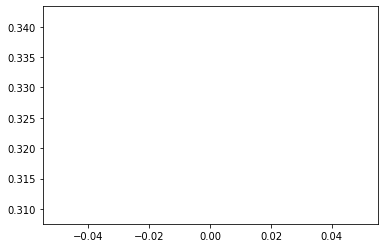

In [15]:
EPOCHS = 100000
patience = 30
stopped_epoch = 0
best = np.Inf
wait = 0
PATH = 'Mymodel'

lossHistory = []
    
for t in range(EPOCHS):
    clear_output(wait=True)
    #if t%50 == 0:
    #    clear_output(wait=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    testLoss = test(test_dataloader, model, loss_fn)
    lossHistory.append(testLoss)
    
    if testLoss < best:
        best = testLoss
        torch.save(model.state_dict(), PATH)
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            stopped_epoch = t
            device = torch.device("cuda")
            model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
            model.to(device)
            break
    
print("Done!")

plt.plot(lossHistory)
plt.title('InputType' + str(inputType))
plt.tight_layout()
plt.savefig('InputType' + str(inputType) + '_' + root + '_LossGraph')
plt.close()

In [36]:
root = 'Dataset'
getResults(root=root, numFrame=10, modelBased = False, drawing = False)

GYH_00
GYH_01
GYH_02
GYH_03
GYH_04
GYH_05
GYH_06
GYH_07
GYH_08
GYH_09
GYH_10
GYH_11
GYH_12
GYH_13
GYH_14
GYH_15
GYH_16
GYH_17
GYH_18
GYH_19
GYH_20
GYH_22
GYH_23
GYH_24
GYH_25
GYH_26
contact negative
['LBL_01', 'LBL_03', 'LBL_05', 'LBL_06', 'LBL_07', 'LBL_08', 'LBL_09', 'LBL_10', 'LBL_11', 'LBL_12', 'LBL_13', 'LBL_15', 'LBL_16', 'LBL_18', 'LBL_19', 'LBL_20', 'LBL_21', 'LBL_22', 'LBL_23', 'LBL_24', 'LBL_25', 'LBL_26', 'LBL_28', 'LBL_29', 'PHE_04', 'PHE_06', 'PHE_07', 'PHE_10', 'PHE_11', 'PHE_13', 'PHE_16', 'PHE_19', 'PHE_21', 'PHE_29', 'LKO_21', 'LKO_25', 'SOS_02', 'SOS_03', 'SOS_04', 'SOS_09', 'SOS_12', 'SOS_13', 'SOS_17', 'SOS_23', 'SOS_24', 'SOS_28', 'SOS_29', 'SOS_29', 'KMK_05', 'KMK_05', 'KMK_10', 'KMK_10', 'KMK_14', 'KMK_18', 'KMK_18', 'KMK_19', 'KMK_19', 'LJE_00', 'LJE_13', 'LJE_23', 'HSN_00', 'HSN_03', 'HSN_04', 'HSN_06', 'HSN_07', 'HSN_26', 'KHM_01', 'KHM_08', 'KHM_12', 'KHM_15', 'KHM_16', 'KHM_18', 'KHM_19', 'KHM_20', 'KHM_28', 'LSJ_11', 'LSJ_26', 'LSJ_28', 'BYS_01', 'BYS_05', 